# Analyse der Simulationsergebnisse und Erstellen von Plots

### Einladen der Abflussreihen

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import glob
import numpy as np
import os

Festlegen der Gebiets-ID und der Pfade

In [ ]:
ID = 3

pfad_messung = ".../Messungen/"
pfad_ergebnisse = ".../results/"
pfad_area = ".../output_data/camels_de/CAMELS_DE_area_attributes.csv"

In [ ]:
# Einladen der Fläche des Einzugsgebiets:
df_area = pd.read_csv(pfad_area, sep=",", header=0)
area_km2 = df_area[df_area["gauge_id"] == ID]["area"].values[0]
print(f"Fläche des Einzugsgebiets: {area_km2} km²")

# Einladen der gemessenen Zeitreihen:
muster_messung = f"{pfad_messung}{ID}_*.csv"
dateien_messung = glob.glob(muster_messung)

if len(dateien_messung) > 0:
    datei = dateien_messung[0]
    print(f"Lade Datei: {datei}")
    
    # Einlesen und Vorverarbeitung der Messungsdatei
    df_messung = pd.read_csv(datei, sep=";", parse_dates=["Datum"], dayfirst=True)
    df_messung["Abfluss"] = df_messung["Abfluss"].str.replace(",", ".").astype(float)  # Komma zu Punkt

    # Umrechung von m³/s in mm/d mit der Fläche des Einzugsgebiets
    df_messung["Abfluss"] = df_messung["Abfluss"] * 86.4 / area_km2

    df_messung = df_messung.rename(columns={"Abfluss": "discharge_spec_obs"})  # Spalte umbenennen
    print(df_messung.head())
else:
    print("Fehler beim Importieren der Messungen")

# Einladen der Ergebnisse der Simulation:
muster_sim_lstm = f"{pfad_ergebnisse}{ID}_results.csv"
dateien_sim_lstm = glob.glob(muster_sim_lstm)

if len(dateien_sim_lstm) > 0:
    datei = dateien_sim_lstm[0]
    print(f"Lade Datei: {datei}")
    
    # Einlesen und Vorverarbeitung der Ergebnissdatei
    df_sim_lstm = pd.read_csv(datei, sep=",", header=0)
    df_sim_lstm.columns.values[0] = "Datum"  # Erste Spalte als "Datum" benennen
    df_sim_lstm["Datum"] = pd.to_datetime(df_sim_lstm["Datum"])  # Datum konvertieren
    df_sim_lstm = df_sim_lstm[["Datum", "y_sim"]]  # `y_obs` ignorieren
    df_sim_lstm = df_sim_lstm.rename(columns={"y_sim": "discharge_spec_sim"})  # Spalte umbenennen
    print(df_sim_lstm.head())
else:
    print("Fehler beim Importieren der Simulationsergebnisse des LSTMs")

# Einladen der Ergebnisse der Panta Rhei Simulation:
muster_sim_pr = f"{pfad_ergebnisse}{ID}_results_PR.xlsx"
dateien_sim_pr = glob.glob(muster_sim_pr)

if len(dateien_sim_pr) > 0:
    datei = dateien_sim_pr[0]
    print(f"Lade Datei: {datei}")
    
    # Einlesen und Vorverarbeitung der Ergebnissdatei
    df_sim_pr = pd.read_excel(datei)
    df_sim_pr["Datum"] = pd.to_datetime(df_sim_pr["Datum"])
    df_sim_pr.set_index("Datum", inplace=True)

    df_sim_pr = df_sim_pr.resample("D").mean()
    df_sim_pr.reset_index(inplace=True)

    print(df_sim_pr.head())
else:
    print("Fehler beim Importieren der Simulationsergebnisse von Panta Rhei")

# Einladen der Ergebnisse der Simulation aus CAMELS-DE:
muster_sim_cde = f"{pfad_ergebnisse}{ID}_results_cde.csv"
dateien_sim_cde = glob.glob(muster_sim_cde)

if len(dateien_sim_cde) > 0:
    datei = dateien_sim_cde[0]
    print(f"Lade Datei: {datei}")
    
    # Einlesen und Vorverarbeitung der Ergebnissdatei
    df_sim_cde = pd.read_csv(datei, sep=",", header=0)
    df_sim_cde.columns.values[0] = "Datum"  # Erste Spalte als "Datum" benennen
    df_sim_cde["Datum"] = pd.to_datetime(df_sim_cde["Datum"])  # Datum konvertieren
    df_sim_cde = df_sim_cde[["Datum", "discharge_spec_sim_lstm"]]
    df_sim_cde = df_sim_cde.rename(columns={"discharge_spec_sim_lstm": "discharge_spec_cde"})  # Spalte umbenennen
    print(df_sim_cde.head())
else:
    print("Fehler beim Importieren der Simulationsergebnisse aus CAMELS-DE")

Fläche des Einzugsgebiets: 95.28 km²
Lade Datei: C:/Users/n-bel/BA_Code/Messungen\3_Weitzmühlen.csv
       Datum  discharge_spec_obs  Unnamed: 2
0 1966-11-01            0.516877         NaN
1 1966-11-02            0.516877         NaN
2 1966-11-03            0.516877         NaN
3 1966-11-04            0.553149         NaN
4 1966-11-05            0.634761         NaN
Lade Datei: C:/Users/n-bel/BA_Code/results/3_results.csv
       Datum  discharge_spec_sim
0 2000-01-01                0.65
1 2000-01-02                0.67
2 2000-01-03                0.55
3 2000-01-04                0.55
4 2000-01-05                0.68
Lade Datei: C:/Users/n-bel/BA_Code/results/3_results_PR.xlsx
       Datum  discharge_spec_pr
0 1966-11-01           0.475334
1 1966-11-02           0.472331
2 1966-11-03           0.478076
3 1966-11-04           0.534933
4 1966-11-05           0.666765
Lade Datei: C:/Users/n-bel/BA_Code/results/3_results_cde.csv
       Datum  discharge_spec_cde
0 1951-01-01                

### Zusammenführen der Zeitreihen

In [98]:
# Zusammenführen der Zeitreihen:
df_merged = pd.merge(df_messung, df_sim_lstm, on="Datum", how="outer")  # Outer-Join für alle Datumswerte
df_merged = pd.merge(df_merged, df_sim_pr, on="Datum", how="outer")  
df_merged = pd.merge(df_merged, df_sim_cde, on="Datum", how="outer")
df_merged = df_merged.sort_values(by="Datum")  # Sortierung nach Datum

# Ausgabe der Zeiträume
zeitraum_messung = (df_messung["Datum"].min(), df_messung["Datum"].max())
zeitraum_sim_lstm = (df_sim_lstm["Datum"].min(), df_sim_lstm["Datum"].max())
zeitraum_sim_pr = (df_sim_pr["Datum"].min(), df_sim_pr["Datum"].max())
zeitraum_sim_cde = (df_sim_cde["Datum"].min(), df_sim_cde["Datum"].max())

print("\nZeitraum der Messdaten:")
print(f"Von {zeitraum_messung[0].date()} bis {zeitraum_messung[1].date()}")

print("\nZeitraum der Simulationsergebnisse LSTM:")
print(f"Von {zeitraum_sim_lstm[0].date()} bis {zeitraum_sim_lstm[1].date()}")

print("\nZeitraum der Simulationsergebnisse Panta Rhei:")
print(f"Von {zeitraum_sim_pr[0].date()} bis {zeitraum_sim_pr[1].date()}")

print("\nZeitraum der Simulationsergebnisse aus CAMELS-DE:")
print(f"Von {zeitraum_sim_cde[0].date()} bis {zeitraum_sim_cde[1].date()}")

# Gemeinsamer Zeitraum:
gemeinsamer_zeitraum = (
    max(zeitraum_messung[0], zeitraum_sim_lstm[0], zeitraum_sim_pr[0], zeitraum_sim_cde[0]),
    min(zeitraum_messung[1], zeitraum_sim_lstm[1], zeitraum_sim_pr[1], zeitraum_sim_cde[1])
)

print("\nGemeinsamer Zeitraum (beide Zeitreihen haben Werte):")
if gemeinsamer_zeitraum[0] <= gemeinsamer_zeitraum[1]:
    print(f"Von {gemeinsamer_zeitraum[0].date()} bis {gemeinsamer_zeitraum[1].date()}")
else:
    print("Kein gemeinsamer Zeitraum verfügbar!")

# Filter für gemeinsamen Zeitraum
df_common = df_merged[
    (df_merged["Datum"] >= gemeinsamer_zeitraum[0]) &
    (df_merged["Datum"] <= gemeinsamer_zeitraum[1])
]

# Ergebnis anzeigen
print("\nZusammengeführte Zeitreihen:")
print(df_merged.head())


Zeitraum der Messdaten:
Von 1966-11-01 bis 2023-12-31

Zeitraum der Simulationsergebnisse LSTM:
Von 2000-01-01 bis 2020-12-31

Zeitraum der Simulationsergebnisse Panta Rhei:
Von 1966-11-01 bis 2021-01-01

Zeitraum der Simulationsergebnisse aus CAMELS-DE:
Von 1951-01-01 bis 2020-12-31

Gemeinsamer Zeitraum (beide Zeitreihen haben Werte):
Von 2000-01-01 bis 2020-12-31

Zusammengeführte Zeitreihen:
       Datum  discharge_spec_obs  Unnamed: 2  discharge_spec_sim  \
0 1951-01-01                 NaN         NaN                 NaN   
1 1951-01-02                 NaN         NaN                 NaN   
2 1951-01-03                 NaN         NaN                 NaN   
3 1951-01-04                 NaN         NaN                 NaN   
4 1951-01-05                 NaN         NaN                 NaN   

   discharge_spec_pr  discharge_spec_cde  
0                NaN                 NaN  
1                NaN                 NaN  
2                NaN                 NaN  
3                Na

### Plot zur Übersicht der Zeiträume

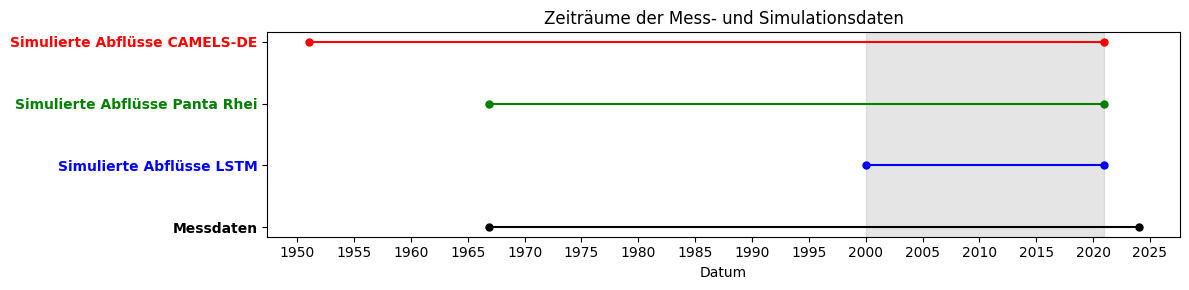

In [ ]:
# Erstellen einer Liste von den Start- und Enddaten für alle DataFrames
datasets = ['Messdaten', 'Simulierte Abflüsse LSTM', 'Simulierte Abflüsse Panta Rhei', 'Simulierte Abflüsse CAMELS-DE']
start_dates = [df_messung["Datum"].min(), df_sim_lstm["Datum"].min(), df_sim_pr["Datum"].min(), df_sim_cde["Datum"].min()]
end_dates = [df_messung["Datum"].max(), df_sim_lstm["Datum"].max(), df_sim_pr["Datum"].max(), df_sim_cde["Datum"].max()]

# Farben für die verschiedenen Datensätze
colors = ["black", "blue", "green", "red"]

# Erstellen des Plots
fig, ax = plt.subplots(figsize=(12, 3))

# Zeiträume der Datensätze mit Farben markieren
for i, (dataset, color) in enumerate(zip(datasets, colors)):
    ax.plot([start_dates[i], end_dates[i]], [i, i], color=color, marker="o", markersize=5)

# Überlappungsbereich berechnen
common_start = max(start_dates)  # Spätester Startzeitpunkt
common_end = min(end_dates)      # Frühestes Enddatum

# Falls es eine Überlappung gibt, Bereich hinterlegen
if common_start < common_end:
    ax.axvspan(common_start, common_end, color="gray", alpha=0.2, label="Überlappungsbereich")

# Y-Achsen-Beschriftung links in entsprechender Farbe setzen
ax.set_yticks(range(len(datasets)))
ax.set_yticklabels([f"{dataset}" for dataset in datasets], fontweight="bold")
for label, color in zip(ax.get_yticklabels(), colors):
    label.set_color(color)

ax.set_xlabel("Datum")
ax.set_title("Zeiträume der Mess- und Simulationsdaten")

# Jahreslabels (alle 5 Jahre)
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))  
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

# Keine vertikalen Grid-Linien
ax.grid(False)

# Den Plot anzeigen
plt.tight_layout()
plt.show()

### Plot der Abflusslinien

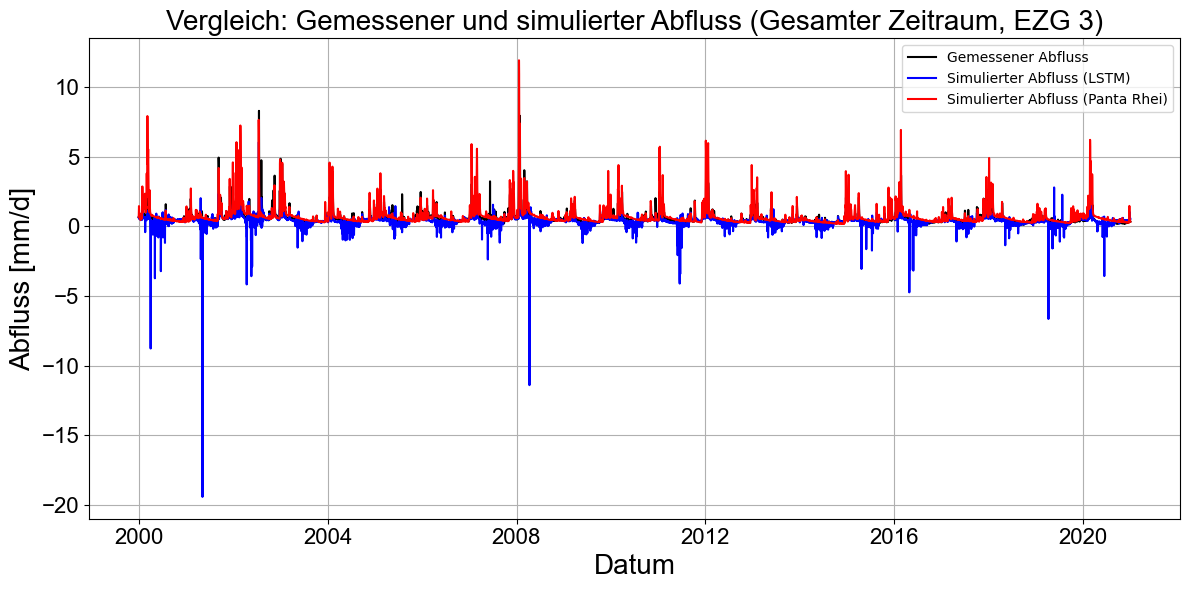

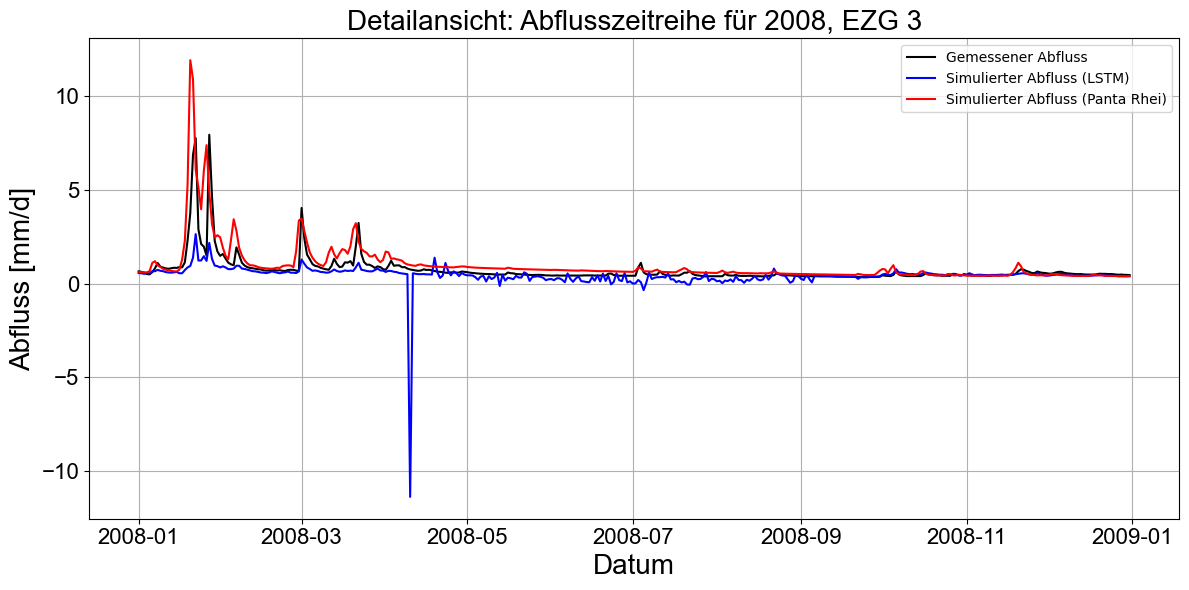

In [ ]:
# Jahr auswählen, das detailliert dargestellt werden soll
selected_year = 2008

# Daten für den gewählten Zeitraum filtern
df_year = df_common[(df_common["Datum"].dt.year == selected_year)]

if not df_common.empty:
    # Hauptplot: Gesamter gemeinsamer Zeitraum
    plt.figure(figsize=(12, 6))
    plt.plot(df_common["Datum"], df_common["discharge_spec_obs"], label="Gemessener Abfluss", color="black")
    plt.plot(df_common["Datum"], df_common["discharge_spec_sim"], label="Simulierter Abfluss (LSTM)", color="blue")
    plt.plot(df_common["Datum"], df_common["discharge_spec_pr"], label="Simulierter Abfluss (Panta Rhei)", color="red")
    plt.xlabel("Datum", fontsize=20, fontname="Arial")
    plt.ylabel("Abfluss [mm/d]", fontsize=20, fontname="Arial")
    plt.title(f"Vergleich: Gemessener und simulierter Abfluss (Gesamter Zeitraum, EZG {ID})", fontsize=20, fontname="Arial")
    plt.legend()
    plt.grid()
    plt.xticks(fontsize=16, fontname="Arial")
    plt.yticks(fontsize=16, fontname="Arial")
    plt.tight_layout()
    plt.show()
    
    # Detailplot für ausgewähltes Jahr
    if not df_year.empty:
        plt.figure(figsize=(12, 6))
        plt.plot(df_year["Datum"], df_year["discharge_spec_obs"], label="Gemessener Abfluss", color="black")
        plt.plot(df_year["Datum"], df_year["discharge_spec_sim"], label="Simulierter Abfluss (LSTM)", color="blue")
        plt.plot(df_year["Datum"], df_year["discharge_spec_pr"], label="Simulierter Abfluss (Panta Rhei)", color="red")
        plt.xlabel("Datum", fontsize=20, fontname="Arial")
        plt.ylabel("Abfluss [mm/d]", fontsize=20, fontname="Arial")
        plt.title(f"Detailansicht: Abflusszeitreihe für {selected_year}, EZG {ID}", fontsize=20, fontname="Arial")
        plt.legend()
        plt.grid()
        plt.xticks(fontsize=16, fontname="Arial")
        plt.yticks(fontsize=16, fontname="Arial")
        plt.tight_layout()
        plt.show()  
    else:
        print(f"Keine Daten für das Jahr {selected_year} verfügbar.")

else:
    print("Kein gemeinsamer Zeitraum für einen Plot verfügbar.")

### Summenlinien

Fläche des Einzugsgebiets: 95.28 km²


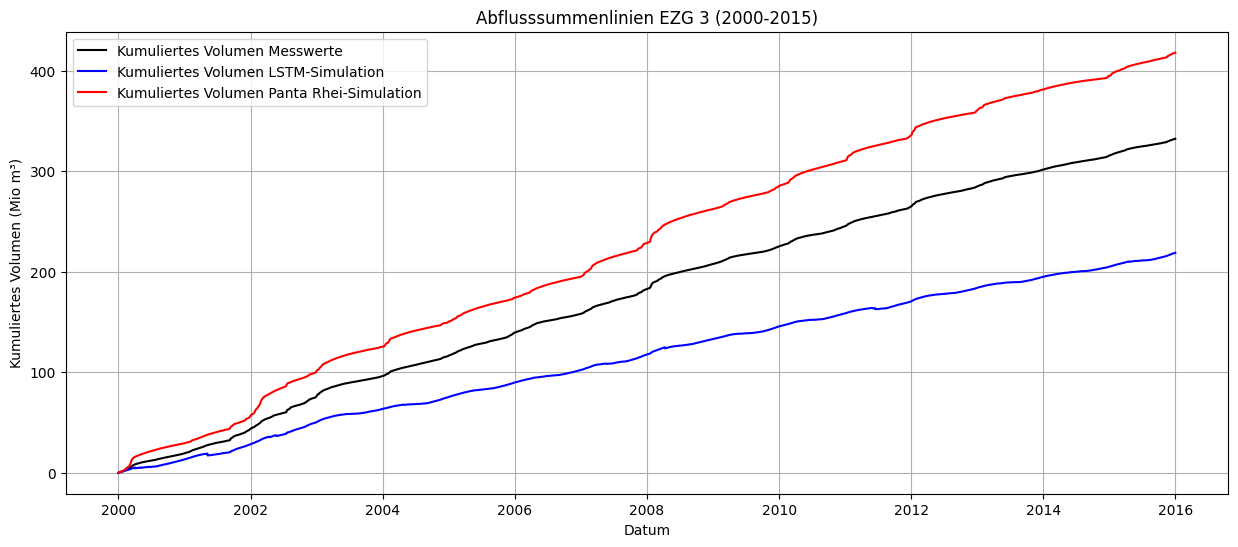

Kumuliertes Volumen Messwerte: 332.19 Mio m³
Kumuliertes Volumen LSTM-Simulation: 218.74 Mio m³
Kumuliertes Volumen Panta Rhei-Simulation: 417.69 Mio m³
           Datum  discharge_spec_obs  Unnamed: 2  discharge_spec_sim  \
17897 2000-01-01            0.680101         NaN                0.65   
17898 2000-01-02            0.680101         NaN                0.67   
17899 2000-01-03            0.625693         NaN                0.55   
17900 2000-01-04            0.770781         NaN                0.55   
17901 2000-01-05            0.852393         NaN                0.68   

       discharge_spec_pr  discharge_spec_cde  Volumen_obs  Volumen_sim  \
17897           0.680777                1.01      64800.0      61932.0   
17898           1.175737                1.02      64800.0      63837.6   
17899           1.460687                1.03      59616.0      52404.0   
17900           1.114216                1.24      73440.0      52404.0   
17901           0.907948                1.26

In [ ]:
# Einladen der Fläche des Einzugsgebiets:
area_km2 = df_area[df_area["gauge_id"] == ID]["area"].values[0]
print(f"Fläche des Einzugsgebiets: {area_km2} km²")

# Umrechnung der Fläche von km² zu m²
area_m2 = area_km2 * 1e6

# Definieren des gewünschten Zeitraums
start_datum = pd.to_datetime("2000-01-01")  # Beispiel-Startdatum
end_datum = pd.to_datetime("2015-12-31")   # Beispiel-Enddatum

# Filtern von df_common für den gewünschten Zeitraum
df_filtered_time = df_common.loc[(df_common["Datum"] >= start_datum) & (df_common["Datum"] <= end_datum)].copy()

# Umrechnung spezifischer Abflusswerte in Volumen (m³) für jeden Tag
df_filtered_time["Volumen_obs"] = df_filtered_time["discharge_spec_obs"] * area_m2 * 0.001
df_filtered_time["Volumen_sim"] = df_filtered_time["discharge_spec_sim"] * area_m2 * 0.001
df_filtered_time["Volumen_pr"] = df_filtered_time["discharge_spec_pr"] * area_m2 * 0.001

# Kumulierte Volumen berechnen
df_filtered_time["Kum_Volumen_obs"] = df_filtered_time["Volumen_obs"].cumsum()
df_filtered_time["Kum_Volumen_sim"] = df_filtered_time["Volumen_sim"].cumsum()
df_filtered_time["Kum_Volumen_pr"] = df_filtered_time["Volumen_pr"].cumsum()

# Plotten der kumulierten Volumen
plt.figure(figsize=(15, 6))
plt.plot(df_filtered_time["Datum"], df_filtered_time["Kum_Volumen_obs"] / 1e6, label="Kumuliertes Volumen Messwerte", color="black")
plt.plot(df_filtered_time["Datum"], df_filtered_time["Kum_Volumen_sim"] / 1e6, label="Kumuliertes Volumen LSTM-Simulation", color="blue")
plt.plot(df_filtered_time["Datum"], df_filtered_time["Kum_Volumen_pr"] / 1e6, label="Kumuliertes Volumen Panta Rhei-Simulation", color="red")
plt.xlabel("Datum")
plt.ylabel("Kumuliertes Volumen (Mio m³)")
plt.title(f"Abflusssummenlinien EZG {ID} ({start_datum.year}-{end_datum.year})")
plt.legend()
plt.grid(True)
plt.show()

# Kumulierte Abflusswerte ausgeben
print(f"Kumuliertes Volumen Messwerte: {df_filtered_time['Kum_Volumen_obs'].iloc[-1] / 1e6:.2f} Mio m³")
print(f"Kumuliertes Volumen LSTM-Simulation: {df_filtered_time['Kum_Volumen_sim'].iloc[-1] / 1e6:.2f} Mio m³")
print(f"Kumuliertes Volumen Panta Rhei-Simulation: {df_filtered_time['Kum_Volumen_pr'].iloc[-1] / 1e6:.2f} Mio m³")
print(df_filtered_time.head())

### Plot 5-Jahreszeitraum
Sehr breiter Plot eines 5 Jahres Zeitraums (nur zu Analysezwecken)

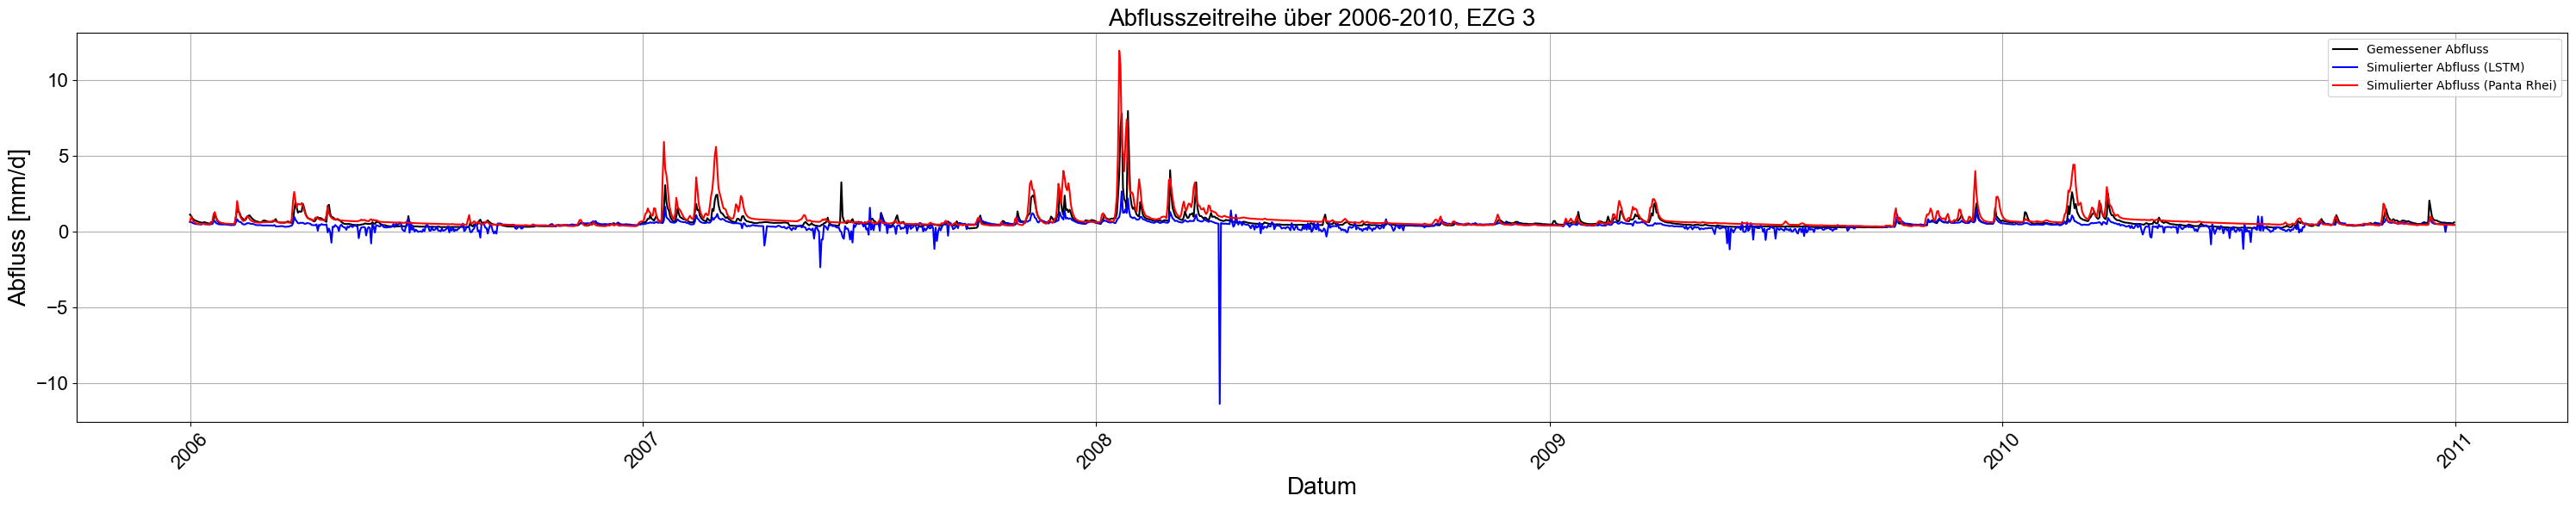

In [102]:
# Fünfjährige Periode wählen (um das ausgewählte Jahr)
year_range = range(selected_year - 2, selected_year + 3)

# Daten für den gewählten Zeitraum filtern
df_five_years = df_common[df_common["Datum"].dt.year.isin(year_range)]

if not df_five_years.empty:
    plt.figure(figsize=(30, 6))  # Breiteres Format für besseren Überblick
    plt.plot(df_five_years["Datum"], df_five_years["discharge_spec_obs"], label="Gemessener Abfluss", color="black")
    plt.plot(df_five_years["Datum"], df_five_years["discharge_spec_sim"], label="Simulierter Abfluss (LSTM)", color="blue")
    plt.plot(df_five_years["Datum"], df_five_years["discharge_spec_pr"], label="Simulierter Abfluss (Panta Rhei)", color="red")
    plt.xlabel("Datum", fontsize=20, fontname="Arial")
    plt.ylabel("Abfluss [mm/d]", fontsize=20, fontname="Arial")
    plt.title(f"Abflusszeitreihe über {min(year_range)}-{max(year_range)}, EZG {ID}", fontsize=20, fontname="Arial")
    plt.legend()
    plt.grid()
    plt.xticks(fontsize=16, fontname="Arial", rotation=45)
    plt.yticks(fontsize=16, fontname="Arial")
    plt.tight_layout()
    plt.show()
else:
    print(f"Keine Daten für den Zeitraum {min(year_range)} - {max(year_range)} verfügbar.")

### Berechnung von Kenngrößen für die Zeitreihen

Bereitstellung der Daten

In [ ]:
# Filtern der Daten für den gemeinsamen Zeitraum (keine NaN-Werte für alle relevanten Spalten)
df_filtered = df_merged.dropna(subset=["discharge_spec_obs", "discharge_spec_sim", "discharge_spec_pr", "discharge_spec_cde"])
print(df_filtered.head())

# Beobachtete Werte
y_obs = df_filtered["discharge_spec_obs"].values
y_obs_kum = df_filtered_time["Kum_Volumen_obs"].iloc[-1]

# Simulierte Werte
y_sim_lstm = df_filtered["discharge_spec_sim"].values
y_sim_pr = df_filtered["discharge_spec_pr"].values
y_sim_cde = df_filtered["discharge_spec_cde"].values

y_sim_kum_lstm = df_filtered_time["Kum_Volumen_sim"].iloc[-1]
y_sim_kum_pr = df_filtered_time["Kum_Volumen_pr"].iloc[-1]

#Ausgabe der kumulierten Abflusswerte in Mio m³
print(f"Kumuliertes Volumen Messwerte: {y_obs_kum / 1e6:.2f} Mio m³")
print(f"Kumuliertes Volumen LSTM-Simulation: {y_sim_kum_lstm / 1e6:.2f} Mio m³")
print(f"Kumuliertes Volumen Panta Rhei-Simulation: {y_sim_kum_pr / 1e6:.2f} Mio m³")

           Datum  discharge_spec_obs  Unnamed: 2  discharge_spec_sim  \
17897 2000-01-01            0.680101         NaN                0.65   
17898 2000-01-02            0.680101         NaN                0.67   
17899 2000-01-03            0.625693         NaN                0.55   
17900 2000-01-04            0.770781         NaN                0.55   
17901 2000-01-05            0.852393         NaN                0.68   

       discharge_spec_pr  discharge_spec_cde  
17897           0.680777                1.01  
17898           1.175737                1.02  
17899           1.460687                1.03  
17900           1.114216                1.24  
17901           0.907948                1.26  
Kumuliertes Volumen Messwerte: 332.19 Mio m³
Kumuliertes Volumen LSTM-Simulation: 218.74 Mio m³
Kumuliertes Volumen Panta Rhei-Simulation: 417.69 Mio m³


Ausgelagerte Funktion zur Berechnung der Kennwerte

In [ ]:
def berechne_kennwerte(y_obs, y_sim):
    # NSE (Nash-Sutcliffe-Effizienz)
    nse = 1 - (np.sum((y_obs - y_sim) ** 2) / np.sum((y_obs - np.mean(y_obs)) ** 2))
    
    # E1' (Modifizierter Nash-Sutcliffe)
    e1_mod = 1 - (np.sum(np.abs(y_obs - y_sim)) / np.sum(np.abs(y_obs - np.mean(y_obs))))
    
    # MBE (Mean Bias Error)
    mbe = np.mean(y_sim - y_obs)
    
    # r (Pearson-Korrelationskoeffizient)
    r = np.corrcoef(y_obs, y_sim)[0, 1]
    
    # Berechnung des KGE (Kling-Gupta-Effizienz)
    mu_obs = np.mean(y_obs)
    mu_sim = np.mean(y_sim)

    sigma_obs = np.std(y_obs)
    sigma_sim = np.std(y_sim)
    
    # Relative Variabilität (Alpha)
    alpha = sigma_sim / sigma_obs
    
    # Normalisierter Bias (Beta)
    beta = mu_sim / mu_obs

    # KGE nach Gupta et al. (2009)
    kge = 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)
    
    # Berechnung des logNSE
    epsilon = 1e-10  # Um log(0) zu vermeiden
    y_obs = np.clip(y_obs, epsilon, None)
    y_sim = np.clip(y_sim, epsilon, None)

    # Logarithmus der Werte
    log_y_obs = np.log(y_obs)
    log_y_sim = np.log(y_sim)
    
    # logNSE Berechnung
    lognse = 1 - (np.sum((log_y_obs - log_y_sim) ** 2) / np.sum((log_y_obs - np.mean(log_y_obs)) ** 2)) if len(y_obs) > 0 else np.nan

    # Alle Werte auf zwei Nachkommastellen runden
    return {
        "NSE": round(nse, 2),
        "E1'": round(e1_mod, 2),
        "MBE": round(mbe, 2),
        "r": round(r, 2),
        "KGE": round(kge, 2),
        "logNSE": round(lognse, 2)
    }

#Berechnung des PBIAS (Percent Bias)
def berechne_PBIAS (y_obs_kum, y_sim_kum):
    pbias = 100 * np.sum(y_obs_kum - y_sim_kum) / np.sum(y_obs_kum)
    return {"PBIAS": round(pbias, 2)}     

Berechnung und Ausgabe der Kennwerte

In [ ]:
# Berechnung der Kennwerte für LSTM und Panta Rhei
kennwerte_lstm = berechne_kennwerte(y_obs, y_sim_lstm)
kennwerte_pr = berechne_kennwerte(y_obs, y_sim_pr)
kennwerte_cde = berechne_kennwerte(y_obs, y_sim_cde)

# Berechnung des PBIAS für LSTM und Panta Rhei
pbias_lstm = berechne_PBIAS(y_obs_kum, y_sim_kum_lstm)
pbias_pr = berechne_PBIAS(y_obs_kum, y_sim_kum_pr)

# Ergebnisse ausgeben
print("\nKennwerte für LSTM-Simulation:")
for key, value in kennwerte_lstm.items():
    print(f"{key}: {value:.2f}")
for key, value in pbias_lstm.items():
    print(f"{key}: {value:.2f}")

print("\nKennwerte für Panta Rhei-Simulation:")
for key, value in kennwerte_pr.items():
    print(f"{key}: {value:.2f}")
for key, value in pbias_pr.items():
    print(f"{key}: {value:.2f}")

print("\nKennwerte für CAMELS-DE-Simulation:")
for key, value in kennwerte_cde.items():
    print(f"{key}: {value:.2f}")


Kennwerte für LSTM-Simulation:
NSE: -0.48
E1': 0.05
MBE: -0.18
r: 0.40
KGE: 0.31
logNSE: -103.00
PBIAS: 34.15

Kennwerte für Panta Rhei-Simulation:
NSE: -0.45
E1': 0.04
MBE: 0.16
r: 0.75
KGE: 0.23
logNSE: 0.36
PBIAS: -25.74

Kennwerte für CAMELS-DE-Simulation:
NSE: 0.34
E1': -0.20
MBE: 0.27
r: 0.89
KGE: 0.50
logNSE: -0.03


### Abflussdauerlinie

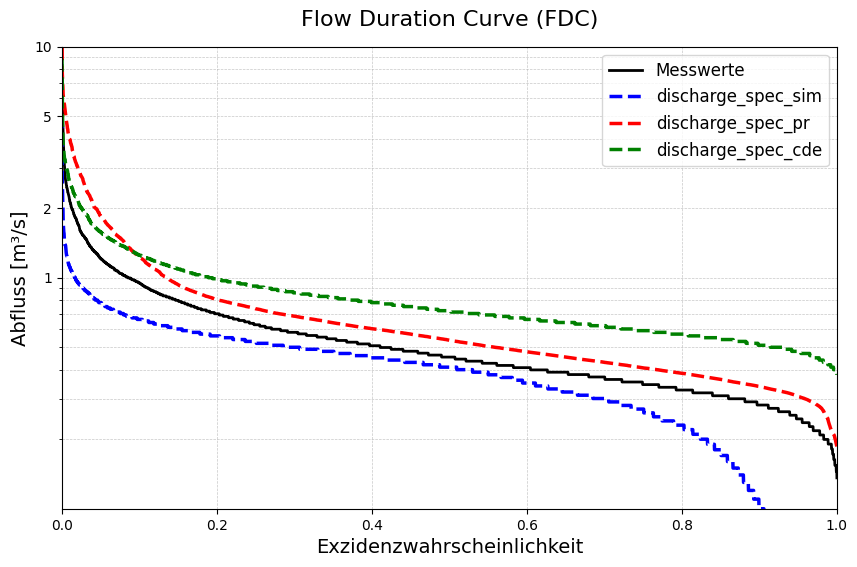

In [ ]:
df = df_common  # Gemeinsames DataFrame

# Funktion zur Berechnung der FDC
def flow_duration_curve(flow_series):
    sorted_flow = np.sort(flow_series)[::-1]  # Sortiere absteigend
    exceedance_prob = np.arange(1, len(sorted_flow) + 1) / len(sorted_flow)  # Exzidenzwahrscheinlichkeit
    return exceedance_prob, sorted_flow

# Messwerte und Simulationen
observed_flow = df["discharge_spec_obs"]
simulation_columns = {
    "discharge_spec_sim": "blue",
    "discharge_spec_pr": "red",
    "discharge_spec_cde": "green"
}

# Plot der FDC
plt.figure(figsize=(10, 6))
plt.plot(*flow_duration_curve(observed_flow), label="Messwerte", lw=2, color="black")
for sim_col, color in simulation_columns.items():
    plt.plot(*flow_duration_curve(df[sim_col]), label=sim_col, lw=2.5, linestyle="dashed", color=color)
plt.xlabel("Exzidenzwahrscheinlichkeit", fontsize=14)
plt.ylabel("Abfluss [m³/s]", fontsize=14)
plt.yscale("log")
min_flow = observed_flow.min() * 0.8
max_flow = observed_flow.max() * 1.2
tick_min = 10 ** np.floor(np.log10(min_flow))  # Untere Grenze runden
tick_max = 10 ** np.ceil(np.log10(max_flow))   # Obere Grenze runden
base_ticks = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000])
yticks = base_ticks[(base_ticks >= tick_min) & (base_ticks <= tick_max)]
plt.yticks(yticks, [f"{ytick:.0f}" for ytick in yticks])  # Ganze Zahlen für bessere Lesbarkeit
plt.xlim(0, 1)
plt.ylim(tick_min, tick_max)
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.legend(loc="upper right", fontsize=12, frameon=True)
plt.title("Flow Duration Curve (FDC)", fontsize=16, pad=15)
plt.show()

### Kennzahlen für bestimmte Abflussbereiche

                    ANA (%)  AMA (%)  AHA (%)
discharge_spec_sim   -49.94   -13.32   -78.40
discharge_spec_pr     72.68    17.70    19.20
discharge_spec_cde    12.92    54.70    79.44


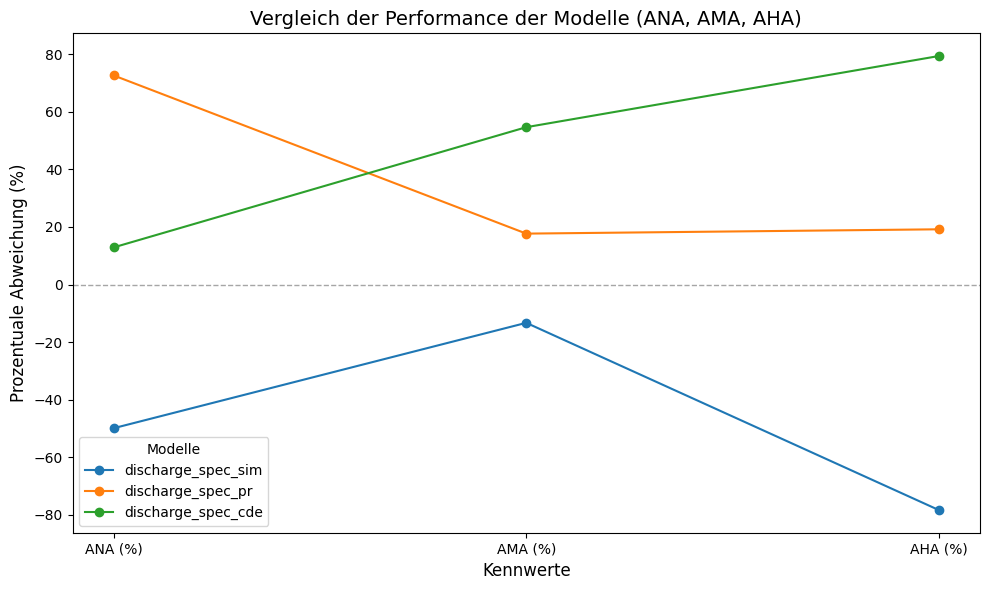

In [ ]:
# Funktion zur Berechnung von ANA, AMA und AHA
def calculate_fdc_metrics(observed, simulated):
    exc_obs, fdc_obs = flow_duration_curve(observed)
    exc_sim, fdc_sim = flow_duration_curve(simulated)

    # High-Flow (obere 2% der FDC)
    high_threshold = 0.02
    high_mask = exc_obs <= high_threshold
    ana = np.sum(fdc_sim[high_mask] - fdc_obs[high_mask]) / np.sum(fdc_obs[high_mask]) * 100

    # Mid-Flow (20-70% der FDC)
    mid_mask = (exc_obs >= 0.2) & (exc_obs <= 0.7)
    ama = np.sum(fdc_sim[mid_mask] - fdc_obs[mid_mask]) / np.sum(fdc_obs[mid_mask]) * 100

    # Low-Flow (untere 30% der FDC)
    low_threshold = 0.3
    low_mask = exc_obs >= (1 - low_threshold)
    aha = np.sum(fdc_sim[low_mask] - fdc_obs[low_mask]) / np.sum(fdc_obs[low_mask]) * 100

    return ana, ama, aha

# Messwerte und Simulationen
observed_flow = df["discharge_spec_obs"]
simulation_columns = ["discharge_spec_sim", "discharge_spec_pr", "discharge_spec_cde"]

# Berechnung für alle Simulationen
results = {}
for sim_col in simulation_columns:
    ana, ama, aha = calculate_fdc_metrics(observed_flow, df[sim_col])
    results[sim_col] = {
        "ANA (%)": round(ana, 2),
        "AMA (%)": round(ama, 2),
        "AHA (%)": round(aha, 2)
    }
    
# Ausgabe der Ergebnisse
results_df = pd.DataFrame(results).T
print(results_df)

# Plotten der Ergebnisse als Liniendiagramm
fig, ax = plt.subplots(figsize=(10, 6))

# Liniendiagramm
for model in results_df.index:
    ax.plot(results_df.columns, results_df.loc[model], marker='o', label=model)

# Horizontale Linie bei 0% als Referenz
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.7)

# Achsentitel und Layout
ax.set_title("Vergleich der Performance der Modelle (ANA, AMA, AHA)", fontsize=14)
ax.set_xlabel("Kennwerte", fontsize=12)
ax.set_ylabel("Prozentuale Abweichung (%)", fontsize=12)
ax.legend(title="Modelle")

# Anzeigen des Plots
plt.tight_layout()
plt.show()

### Abspeichern der Kenngrößen

In [ ]:
# Pfad zur CSV-Datei, in die die Ergebnisse gespeichert werden
pfad_analyse = ".../results/Analyse.csv"

df_results = pd.DataFrame(data={
    "gauge_id": [ID], 
    
    # NSE-Werte für alle Modelle
    "nse_lstm": [kennwerte_lstm["NSE"]],
    "nse_pr": [kennwerte_pr["NSE"]],
    "nse_cde": [kennwerte_cde["NSE"]], 

    # NSE-Werte für alle Modelle
    "lognse_lstm": [kennwerte_lstm["logNSE"]],
    "lognse_pr": [kennwerte_pr["logNSE"]],
    "lognse_cde": [kennwerte_cde["logNSE"]], 

    # E1'-Werte für alle Modelle
    "e1_lstm": [kennwerte_lstm["E1'"]],
    "e1_pr": [kennwerte_pr["E1'"]],
    "e1_cde": [kennwerte_cde["E1'"]], 

    # r-Werte für alle Modelle
    "r_lstm": [kennwerte_lstm["r"]],
    "r_pr": [kennwerte_pr["r"]],
    "r_cde": [kennwerte_cde["r"]], 

    # MBE-Werte für alle Modelle
    "mbe_lstm": [kennwerte_lstm["MBE"]],
    "mbe_pr": [kennwerte_pr["MBE"]],
    "mbe_cde": [kennwerte_cde["MBE"]], 

    # KGE-Werte für alle Modelle
    "kge_lstm": [kennwerte_lstm["KGE"]],
    "kge_pr": [kennwerte_pr["KGE"]],
    "kge_cde": [kennwerte_cde["KGE"]],


    # PBIAS-Werte für alle Modelle
    "pbias_lstm": [pbias_lstm["PBIAS"]],
    "pbias_pr": [pbias_pr["PBIAS"]],

    # ANA-Werte für alle Modelle
    "ana_sim": [results["discharge_spec_sim"]["ANA (%)"]],
    "ana_pr": [results["discharge_spec_pr"]["ANA (%)"]],
    "ana_cde": [results["discharge_spec_cde"]["ANA (%)"]],

    # AMA-Werte für alle Modelle
    "ama_sim": [results["discharge_spec_sim"]["AMA (%)"]],
    "ama_pr": [results["discharge_spec_pr"]["AMA (%)"]],
    "ama_cde": [results["discharge_spec_cde"]["AMA (%)"]],

    # AHA-Werte für alle Modelle
    "aha_sim": [results["discharge_spec_sim"]["AHA (%)"]],
    "aha_pr": [results["discharge_spec_pr"]["AHA (%)"]],
    "aha_cde": [results["discharge_spec_cde"]["AHA (%)"]]
})

# Überprüfen, ob die Datei existiert
if not os.path.isfile(pfad_analyse):
    # Wenn die Datei nicht existiert, speichere mit den Headern
    df_results.to_csv(pfad_analyse, sep=",", header=True, index=False, mode="w")
else:
    # Wenn die Datei existiert, speichere ohne Header
    df_results.to_csv(pfad_analyse, sep=",", header=False, index=False, mode="a")

# Ausgabe zur Bestätigung
print("Ergebnisse wurden gespeichert.")

Ergebnisse wurden gespeichert.
